In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
def load_dataset(dsname):
    metadata = pd.read_csv(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/metadata_final.csv")
    x = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_data0.p", "rb" ))
    y = pickle.load(open(f"/datasets/nicolas_facchinetti/processed_data/{dsname}/processed_labels.p", "rb" ))
    return metadata, x, y

In [3]:
from sklearn.preprocessing import StandardScaler

def standardize(data):
    scaler = StandardScaler()
    n = data.shape
    return scaler.fit_transform(data.reshape(n[0],-1)).reshape(n)

In [4]:
datasets = ["emodb", "emovo", "ravdess"]
data = {}
for d in datasets:
    md, x, y = load_dataset(d)
    data[d] = {}
    data[d]["x"] = standardize(x)
    data[d]["y"] = y
    data[d]["metadata"] = md

Get train/test data

In [5]:
from sklearn.model_selection import train_test_split

train = {}
test = {}
for d in datasets:
    train[d] = {}
    test[d] = {}
    train_df, test_df = train_test_split(data[d]['metadata'], 
                                       test_size = 0.2, 
                                       random_state = 1938,
                                       stratify = data[d]['metadata']['label'])
    train_index = train_df.index
    test_index = test_df.index
    train[d]['x'] = data[d]['x'][train_index]
    train[d]['y'] = data[d]['y'][train_index]
    test[d]['x']= data[d]['x'][test_index]
    test[d]['y']= data[d]['y'][test_index]
    

In [6]:
data['emodb']['y'].shape, train['emodb']['y'].shape, test['emodb']['y'].shape

((4181, 5), (3344, 5), (837, 5))

# Model hyperparameter

Find the optimal number of LSTM unit for each dataset

In [7]:
import tensorflow as tf
import tensorflow.keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization, Bidirectional

2023-02-28 11:36:01.188418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [8]:
def get_m1(hp):
    # Define hyper model architecture
    m = Sequential([
        InputLayer(input_shape=(261,128,1)),
        Reshape((9,29,128,1)),
        TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

        TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

        TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        TimeDistributed(Flatten()),
        
        # Tune number of units (4, 8, 16, 32, 64, 128, 256, 512, 1024)
        Bidirectional(LSTM(hp.Choice("lstm_units",  values=[4, 8, 16, 32, 64, 128, 256, 512, 1024]),
                           dropout=0.2,
                           return_sequences=False)),
        Dense(5, activation='softmax')
    ])
    
    
    # Define optimizer, loss, and metrics
    m.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])
    return m

In [9]:
def search_lstm(ds):
    # instantiate the tuner
    tuner = kt.tuners.Hyperband(get_m1,
                                objective="val_loss",
                                max_epochs=120,
                                # number of models that should be built and fit for each trial with the same hyperparameter values
                                executions_per_trial=3,
                                # the reduction factor for the number of epochs and number of models for each bracket
                                factor=15,
                                # the number of times to iterate over the full Hyperband algorithm
                                hyperband_iterations=3,
                                overwrite=True,
                                directory="/datasets/nicolas_facchinetti/kt_dir1",
                                project_name="cnnlstm1")

    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

    tuner.search(train[ds]['x'], train[ds]['y'],
                 epochs=100,
                 validation_split=0.2,
                 callbacks=[earlyStopping, reduce_lr_loss],
                 verbose=2)

    tuner.results_summary()

In [10]:
res1 = search_lstm('emodb')

Trial 9 Complete [00h 01m 41s]
val_loss: 0.3975821038087209

Best val_loss So Far: 0.2849500874678294
Total elapsed time: 00h 14m 02s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /datasets/nicolas_facchinetti/kt_dir1/cnnlstm1
Showing 10 best trials
Trial summary
Hyperparameters:
lstm_units: 512
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.2849500874678294
Trial summary
Hyperparameters:
lstm_units: 256
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.2930381695429484
Trial summary
Hyperparameters:
lstm_units: 128
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.30164288481076557
Trial summary
Hyperparameters:
lstm_units: 1024
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3155254324277242
Trial summary
Hyperparameters:
lstm_units: 64
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3293354610602061
Trial summ

In [11]:
res2 = search_lstm('emovo')

Trial 9 Complete [00h 02m 06s]
val_loss: 0.4782815972963969

Best val_loss So Far: 0.47662363449732464
Total elapsed time: 00h 18m 23s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /datasets/nicolas_facchinetti/kt_dir1/cnnlstm1
Showing 10 best trials
Trial summary
Hyperparameters:
lstm_units: 512
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.47662363449732464
Trial summary
Hyperparameters:
lstm_units: 256
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.4782815972963969
Trial summary
Hyperparameters:
lstm_units: 1024
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.4845413863658905
Trial summary
Hyperparameters:
lstm_units: 128
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5194460848967234
Trial summary
Hyperparameters:
lstm_units: 64
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5630144874254862
Trial sum

In [12]:
res3 = search_lstm('ravdess')

Trial 9 Complete [00h 02m 40s]
val_loss: 0.4444417556126912

Best val_loss So Far: 0.30376137296358746
Total elapsed time: 00h 25m 11s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /datasets/nicolas_facchinetti/kt_dir1/cnnlstm1
Showing 10 best trials
Trial summary
Hyperparameters:
lstm_units: 1024
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.30376137296358746
Trial summary
Hyperparameters:
lstm_units: 256
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3299727439880371
Trial summary
Hyperparameters:
lstm_units: 512
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.33017777403195697
Trial summary
Hyperparameters:
lstm_units: 128
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.3831322391827901
Trial summary
Hyperparameters:
lstm_units: 64
tuner/epochs: 8
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.4444417556126912
Trial su

Going with 256 LSTM units enure great perfomance boost with a lower risk of overfitting

In [13]:
def get_m():
    # Define hyper model architecture
    m = Sequential([
        InputLayer(input_shape=(261,128,1)),
        Reshape((9,29,128,1)),
        TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

        TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

        TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        TimeDistributed(Flatten()),
        
        Bidirectional(LSTM(256,
                           dropout=0.2,
                           return_sequences=False)),
        Dense(5, activation='softmax')
    ])
    
    
    return m

get_m().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_10 (TimeDis (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 9, 2, 27, 64)     

### Test LSTM architecture

In [14]:
def train_evaluate(ds):
    m = get_m()
    m.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')
    
    # fit & predict
    history = m.fit(train[ds]['x'], train[ds]['y'],
                    epochs=50,
                    batch_size=32,
                    callbacks=[earlyStopping, reduce_lr_loss],
                    validation_split=0.2,
                    verbose=2)
    # test
    results = m.evaluate(test[ds]['x'], test[ds]['y'], verbose=0)
    print("\t\tTest loss, test acc:", results)
    return history, results

res = {}
for ds in data:
    print(f'\nTraining on {ds}')
    res[ds] = train_evaluate(ds)

In [17]:
start_df = []
for d in res:
    print(f'For {d} test loss: {res[d][1][0]} accuracy: {res[d][1][1]}')
    start_df.append([res[d][1][0], res[d][1][1]])
start_df = pd.DataFrame(start_df, columns=['S loss', 'S acc'], index=res.keys())

For emodb test loss: 0.37915724515914917 accuracy: 0.8888888955116272
For emovo test loss: 0.3849480450153351 accuracy: 0.8733536005020142
For ravdess test loss: 0.35736197233200073 accuracy: 0.87325519323349


In [18]:
start_df

,S loss,S acc
emodb,0.379157,0.888889
emovo,0.384948,0.873354
ravdess,0.357362,0.873255


In [19]:
import matplotlib.pyplot as plt

def plot_res_acc(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_res_loss(h, x, y):
    plt.subplot(x, 2, y)
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_stats(h):
    fig = plt.gcf()
    fig.set_size_inches(15, 6)
    for num, c in enumerate(h):
        n = (num+1)*2
        plot_res_acc(c, len(h), n-1)
        plot_res_loss(c, len(h), n)
    plt.show()

emodb


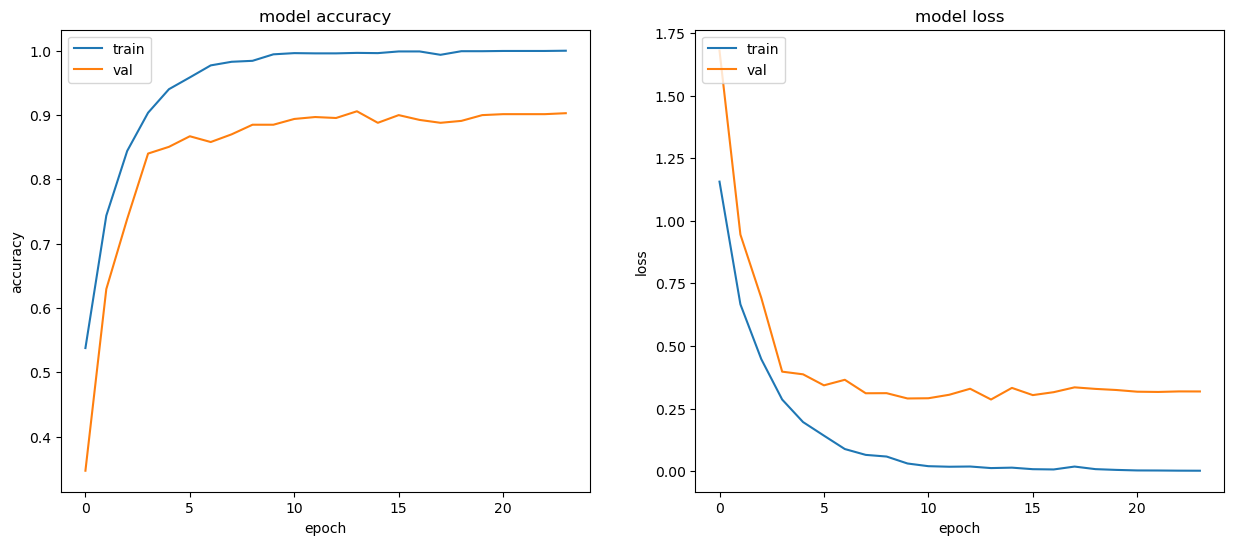

emovo


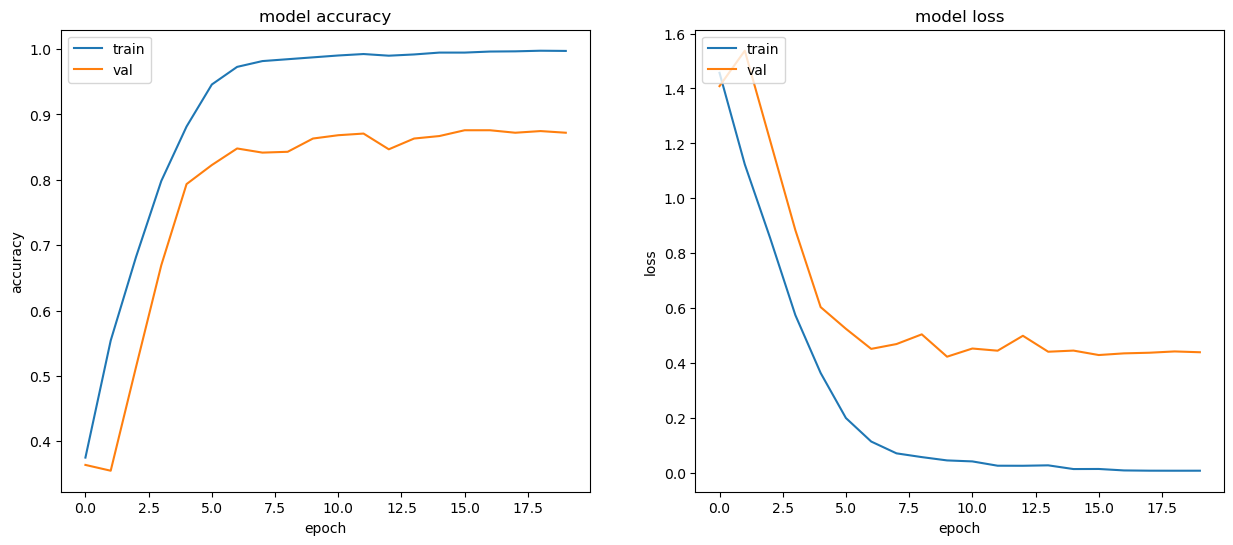

ravdess


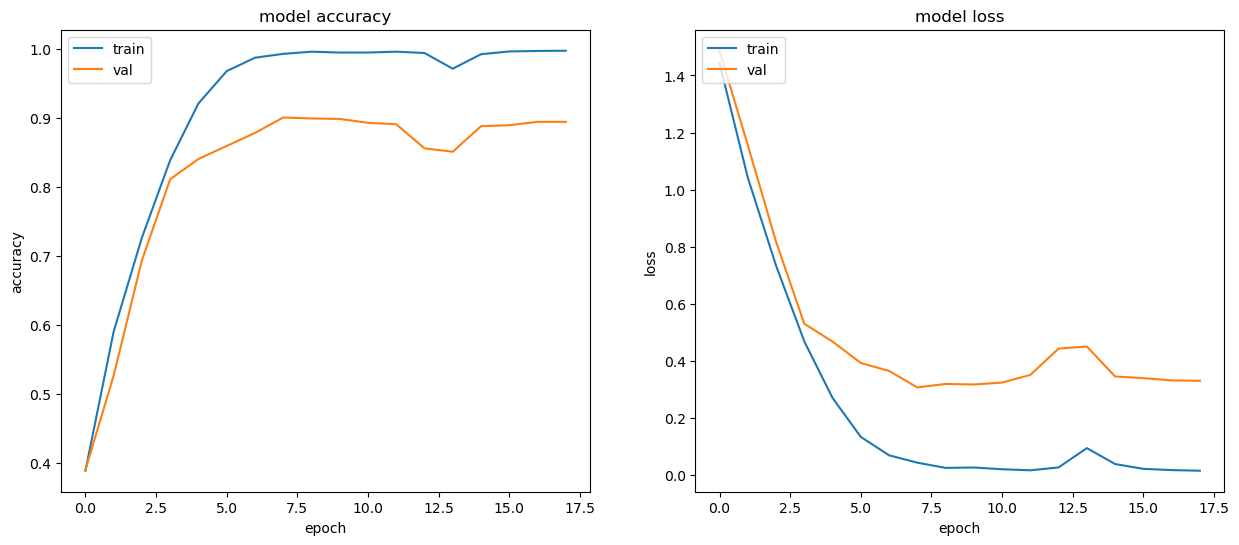

In [20]:
for s in res:
    print(s)
    plot_stats([res[s][0]])

# Algorithm hyperparameter

Adjust algorithm training hyperparameter plus minor parameter like dropout

In [135]:
def get_m2(hp):
    # Define hyper model architecture
    m = Sequential([
        InputLayer(input_shape=(261,128,1)),
        Reshape((9,29,128,1)),
        TimeDistributed(Conv2D(16, kernel_size=(5,5), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(4,4), strides=2)),

        TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=2)),

        TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=1)),
        TimeDistributed(Flatten()),
        
        # Tune dropout layer with values in 0 - 0.6 with stepsize of 0.3
        Dropout(hp.Float("dropout", min_value=0, max_value=0.6, step=0.3)),
        
        # Tune dropout probability (values in 0 - 0.4 with stepsize of 0.2)
        Bidirectional(LSTM(256,
                           dropout=hp.Float("lstm_dropout", min_value=0, max_value=0.4, step=0.2),
                           return_sequences=False)),
        Dense(5, activation='softmax')
    ])
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss='categorical_crossentropy',
              metrics=["accuracy"])
    return m

In [143]:
class MyTuner(kt.tuners.Hyperband):
      def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Choice("batch_size", values=[8, 16, 32, 64, 128])
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [145]:
# instantiate the tuner
tuner1 = MyTuner(get_m2,
                 objective="val_loss",
                 max_epochs=120,
                 # number of models that should be built and fit for each trial with the same hyperparameter values
                 executions_per_trial=3,
                 # the reduction factor for the number of epochs and number of models for each bracket
                 factor=15,
                 # the number of times to iterate over the full Hyperband algorithm
                 hyperband_iterations=3,
                 overwrite=True,
                 directory="/datasets/nicolas_facchinetti/kt_dir2",
                 project_name="cnnlstm2")
tuner1.search_space_summary()

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')

tuner1.search(train['emodb']['x'], train['emodb']['y'],
             epochs=100,
             validation_split=0.2,
             callbacks=[earlyStopping, reduce_lr_loss],
             verbose=2)

Trial 84 Complete [00h 06m 33s]
val_loss: 0.2943439881006877

Best val_loss So Far: 0.24255329370498657
Total elapsed time: 01h 56m 43s
INFO:tensorflow:Oracle triggered exit


In [233]:
tuner1.results_summary()

Results summary
Results in /datasets/nicolas_facchinetti/kt_dir2/cnnlstm2
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.2
learning_rate: 0.001
batch_size: 32
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0050
lstm_units: 2
Score: 0.24255329370498657
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.2
learning_rate: 0.001
batch_size: 16
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0058
Score: 0.24965617060661316
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.4
learning_rate: 0.001
batch_size: 16
tuner/epochs: 120
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.2517334371805191
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.4
learning_rate: 0.001
batch_size: 32
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0073
Score: 0.25494201978047687
Trial summary
Hyperparameters:
drop

In [152]:
tuner2 = MyTuner(get_m2,
                 objective="val_loss",
                 max_epochs=120,
                 # number of models that should be built and fit for each trial with the same hyperparameter values
                 executions_per_trial=3,
                 # the reduction factor for the number of epochs and number of models for each bracket
                 factor=15,
                 # the number of times to iterate over the full Hyperband algorithm
                 hyperband_iterations=3,
                 overwrite=True,
                 directory="/datasets/nicolas_facchinetti/kt_dir3",
                 project_name="cnnlstm3")
tuner2.search_space_summary()

tuner2.search(train['emovo']['x'], train['emovo']['y'],
             epochs=100,
             validation_split=0.2,
             callbacks=[earlyStopping, reduce_lr_loss],
             verbose=2)

Trial 84 Complete [00h 02m 01s]
val_loss: 1.5282885630925496

Best val_loss So Far: 0.36417991916338605
Total elapsed time: 02h 22m 06s
INFO:tensorflow:Oracle triggered exit


In [153]:
tuner2.results_summary()

Results summary
Results in /datasets/nicolas_facchinetti/kt_dir3/cnnlstm3
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.0
learning_rate: 0.0001
batch_size: 8
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0001
Score: 0.36417991916338605
Trial summary
Hyperparameters:
dropout: 0.0
lstm_dropout: 0.2
learning_rate: 0.0001
batch_size: 8
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0057
Score: 0.3771323362986247
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.4
learning_rate: 0.0001
batch_size: 16
tuner/epochs: 120
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.3842690885066986
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.2
learning_rate: 0.0001
batch_size: 32
tuner/epochs: 120
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.3907069265842438
Trial summary
Hyperparameters:
dropout: 0.0
lstm_dropout: 0.0
learning

In [154]:
tuner3 = MyTuner(get_m2,
                 objective="val_loss",
                 max_epochs=120,
                 # number of models that should be built and fit for each trial with the same hyperparameter values
                 executions_per_trial=3,
                 # the reduction factor for the number of epochs and number of models for each bracket
                 factor=15,
                 # the number of times to iterate over the full Hyperband algorithm
                 hyperband_iterations=3,
                 overwrite=True,
                 directory="/datasets/nicolas_facchinetti/kt_dir4",
                 project_name="cnnlstm4")
tuner3.search_space_summary()

tuner3.search(train['ravdess']['x'], train['ravdess']['y'],
             epochs=100,
             validation_split=0.2,
             callbacks=[earlyStopping, reduce_lr_loss],
             verbose=2)

Trial 84 Complete [00h 03m 28s]
val_loss: 0.3047107756137848

Best val_loss So Far: 0.24022861818472543
Total elapsed time: 03h 52m 46s
INFO:tensorflow:Oracle triggered exit


In [155]:
tuner3.results_summary()

Results summary
Results in /datasets/nicolas_facchinetti/kt_dir4/cnnlstm4
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.6
lstm_dropout: 0.2
learning_rate: 0.001
batch_size: 128
tuner/epochs: 120
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.24022861818472543
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.0
learning_rate: 0.001
batch_size: 64
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0039
Score: 0.27419041593869525
Trial summary
Hyperparameters:
dropout: 0.0
lstm_dropout: 0.4
learning_rate: 0.001
batch_size: 64
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0066
Score: 0.27864599227905273
Trial summary
Hyperparameters:
dropout: 0.3
lstm_dropout: 0.2
learning_rate: 0.001
batch_size: 64
tuner/epochs: 120
tuner/initial_epoch: 8
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0011
Score: 0.2835317353407542
Trial summary
Hyperparameters:
dropout: 0.0
lstm

In [184]:
# Get the optimal hyperparameters from the results
param_found = {'emodb': tuner1,
               'emovo': tuner2,
               'ravdess': tuner3}

In [185]:
for d in param_found:
    print(f'For {d} the best found paramters are:')
    print(param_found[d].get_best_hyperparameters()[0].get_config()["values"])

For emodb the best found paramters are:
{'dropout': 0.3, 'lstm_dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'tuner/epochs': 120, 'tuner/initial_epoch': 8, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0050', 'lstm_units': 2}
For emovo the best found paramters are:
{'dropout': 0.3, 'lstm_dropout': 0.0, 'learning_rate': 0.0001, 'batch_size': 8, 'tuner/epochs': 120, 'tuner/initial_epoch': 8, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0001', 'lstm_units': 2}
For ravdess the best found paramters are:
{'dropout': 0.6, 'lstm_dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'tuner/epochs': 120, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0, 'lstm_units': 2}


### Test hyperparameter

In [28]:
final_res = {}

for d in param_found:
    print(d)
    # Build model
    params = param_found[d].get_best_hyperparameters()[0]
    h_model = param_found[d].hypermodel.build(params)
    h_model.summary()
    # Train the hypertuned model
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_delta=1e-4, mode='min')
    history = h_model.fit(train[d]['x'], train[d]['y'],
                          epochs=100,
                          batch_size=params.get_config()["values"]["batch_size"],
                          validation_split=0.2,
                          callbacks=[earlyStopping, reduce_lr_loss], verbose=2)
    
    # Evaluate model on test set
    results = h_model.evaluate(test[d]['x'], test[d]['y'],
                               batch_size=params.get_config()["values"]["batch_size"]
                               )
    print("Test loss, test acc:", results)
    final_res[d] = [history, results]

emodb
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 9, 29, 128, 1)     0         
_________________________________________________________________
time_distributed_64 (TimeDis (None, 9, 25, 124, 16)    416       
_________________________________________________________________
time_distributed_65 (TimeDis (None, 9, 25, 124, 16)    64        
_________________________________________________________________
time_distributed_66 (TimeDis (None, 9, 11, 61, 16)     0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 9, 9, 59, 32)      4640      
_________________________________________________________________
time_distributed_68 (TimeDis (None, 9, 4, 29, 32)      0         
_________________________________________________________________
time_distributed_69 (TimeDis (None, 9, 2, 27, 64

Epoch 7/100
395/395 - 4s - loss: 0.2982 - accuracy: 0.9071 - val_loss: 0.4948 - val_accuracy: 0.8251
Epoch 8/100
395/395 - 4s - loss: 0.2230 - accuracy: 0.9407 - val_loss: 0.4449 - val_accuracy: 0.8555
Epoch 9/100
395/395 - 4s - loss: 0.1716 - accuracy: 0.9525 - val_loss: 0.4937 - val_accuracy: 0.8251
Epoch 10/100
395/395 - 4s - loss: 0.1390 - accuracy: 0.9677 - val_loss: 0.4403 - val_accuracy: 0.8454
Epoch 11/100
395/395 - 4s - loss: 0.0982 - accuracy: 0.9762 - val_loss: 0.4638 - val_accuracy: 0.8466
Epoch 12/100
395/395 - 4s - loss: 0.0763 - accuracy: 0.9848 - val_loss: 0.4343 - val_accuracy: 0.8492
Epoch 13/100
395/395 - 4s - loss: 0.0616 - accuracy: 0.9880 - val_loss: 0.4145 - val_accuracy: 0.8707
Epoch 14/100
395/395 - 4s - loss: 0.0492 - accuracy: 0.9889 - val_loss: 0.3887 - val_accuracy: 0.8669
Epoch 15/100
395/395 - 4s - loss: 0.0530 - accuracy: 0.9880 - val_loss: 0.3884 - val_accuracy: 0.8745
Epoch 16/100
395/395 - 4s - loss: 0.0393 - accuracy: 0.9911 - val_loss: 0.4481 - val_

Epoch 30/100
45/45 - 2s - loss: 0.0371 - accuracy: 0.9907 - val_loss: 0.2590 - val_accuracy: 0.9246
Epoch 31/100
45/45 - 2s - loss: 0.0387 - accuracy: 0.9900 - val_loss: 0.2674 - val_accuracy: 0.9100
Epoch 32/100
45/45 - 2s - loss: 0.0385 - accuracy: 0.9897 - val_loss: 0.2891 - val_accuracy: 0.9149
Epoch 33/100
45/45 - 2s - loss: 0.0418 - accuracy: 0.9890 - val_loss: 0.2871 - val_accuracy: 0.9184
Epoch 34/100
45/45 - 2s - loss: 0.0388 - accuracy: 0.9869 - val_loss: 0.2653 - val_accuracy: 0.9239
Epoch 35/100
45/45 - 2s - loss: 0.0361 - accuracy: 0.9871 - val_loss: 0.3089 - val_accuracy: 0.9191
Epoch 36/100
45/45 - 2s - loss: 0.0385 - accuracy: 0.9895 - val_loss: 0.3160 - val_accuracy: 0.9093

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 37/100
45/45 - 2s - loss: 0.0329 - accuracy: 0.9902 - val_loss: 0.2778 - val_accuracy: 0.9191
Epoch 38/100
45/45 - 2s - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.2703 - val_accuracy: 0.9281
Epoch 39/100
45/45

In [29]:
final_df = []
for d in final_res:
    print(f'For {d} test loss: {final_res[d][1][0]} accuracy: {final_res[d][1][1]}')
    final_df.append([final_res[d][1][0], final_res[d][1][1]])
final_df = pd.DataFrame(final_df, columns=['F loss', 'F acc'], index=final_res.keys())

For emodb test loss: 0.3126097321510315 accuracy: 0.9068100452423096
For emovo test loss: 0.34495365619659424 accuracy: 0.8956433534622192
For ravdess test loss: 0.2817017436027527 accuracy: 0.9128978252410889


In [30]:
final_df

,F loss,F acc
emodb,0.312610,0.906810
emovo,0.344954,0.895643
ravdess,0.281702,0.912898


emodb


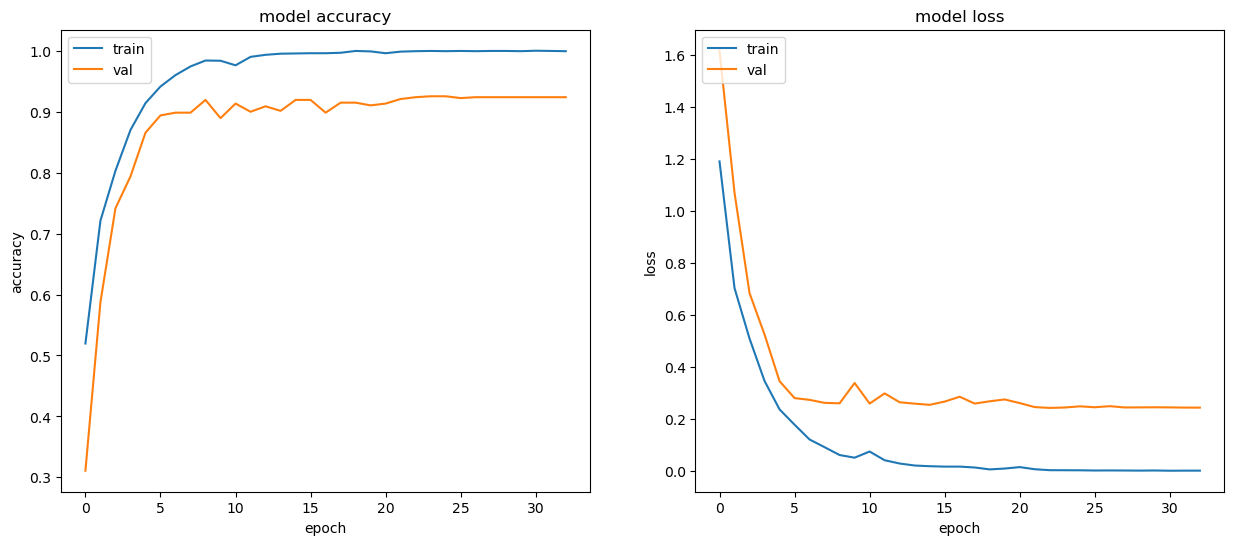

emovo


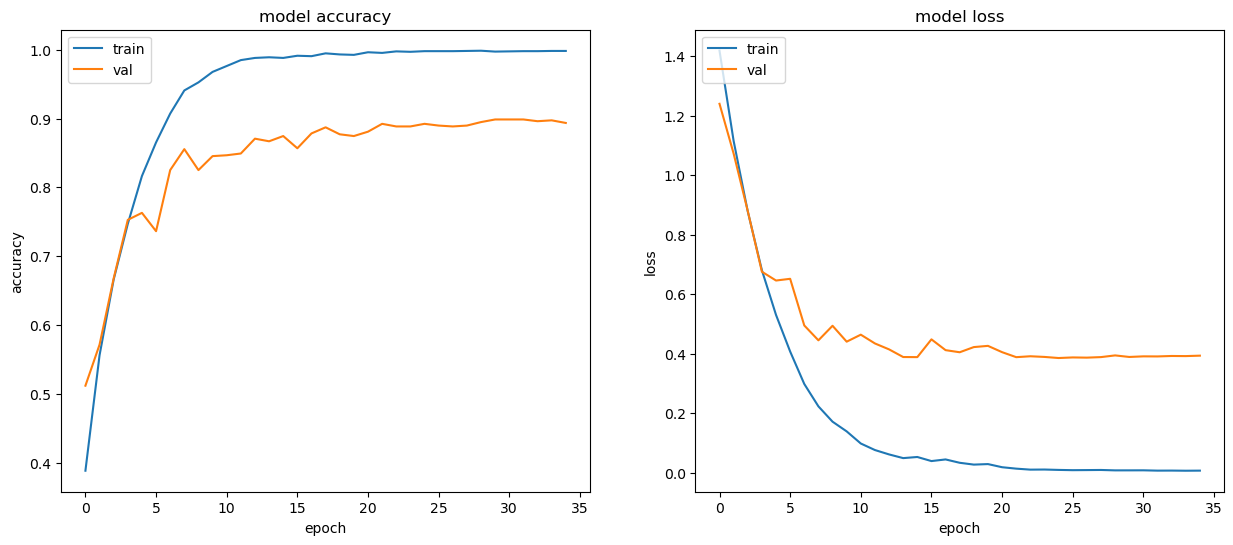

ravdess


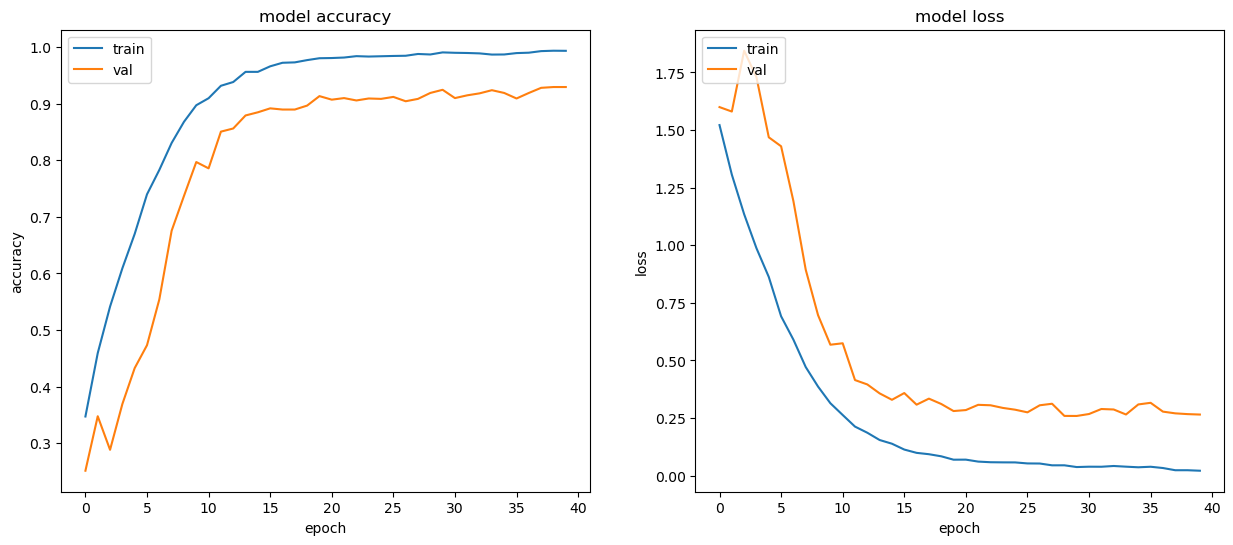

In [31]:
for s in final_res:
    print(s)
    plot_stats([final_res[s][0]])

# Final result

In [32]:
pd.concat([start_df, final_df], axis=1)

,S loss,S acc,F loss,F acc
emodb,0.379157,0.888889,0.312610,0.906810
emovo,0.384948,0.873354,0.344954,0.895643
ravdess,0.357362,0.873255,0.281702,0.912898


In [236]:
import pickle

with open('/datasets/nicolas_facchinetti/param.p', 'wb') as parameters:
    pickle.dump({d: param_found[d].get_best_hyperparameters()[0].get_config()['values']
                 for d in param_found}, parameters)